In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from pathlib import Path
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns # 引入 seaborn 来使用更专业的调色板
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

# 设置字体为Arial
plt.rcParams['font.family'] = 'Arial'

# 读取可行性分析结果数据
data_path = Path("../result/island_viability_summary_electric.csv")
df = pd.read_csv(data_path)

# 显示数据概况
print(f"数据形状: {df.shape}")
print(f"情景列表: {df['scenario'].unique()}")
print(f"Viability gap统计:")
print(df['viability_gap'].describe())



数据形状: (10980, 16)
情景列表: ['output_0' 'output_2020' 'output_2050' 'output_future_2030'
 'output_future_2040' 'output_future_2050']
Viability gap统计:
count    10980.000000
mean        -0.425257
std          0.739480
min         -4.148942
25%         -1.006200
50%          0.043717
75%          0.082420
max          0.954005
Name: viability_gap, dtype: float64


发现 13 个有显著变化的区域: ['BOB', 'EAS', 'ENA', 'NAU', 'NEU', 'NPO', 'NWN', 'NZ', 'RFE', 'SAU', 'SSA', 'SWS', 'WNA']
开始生成三情景云雨图...


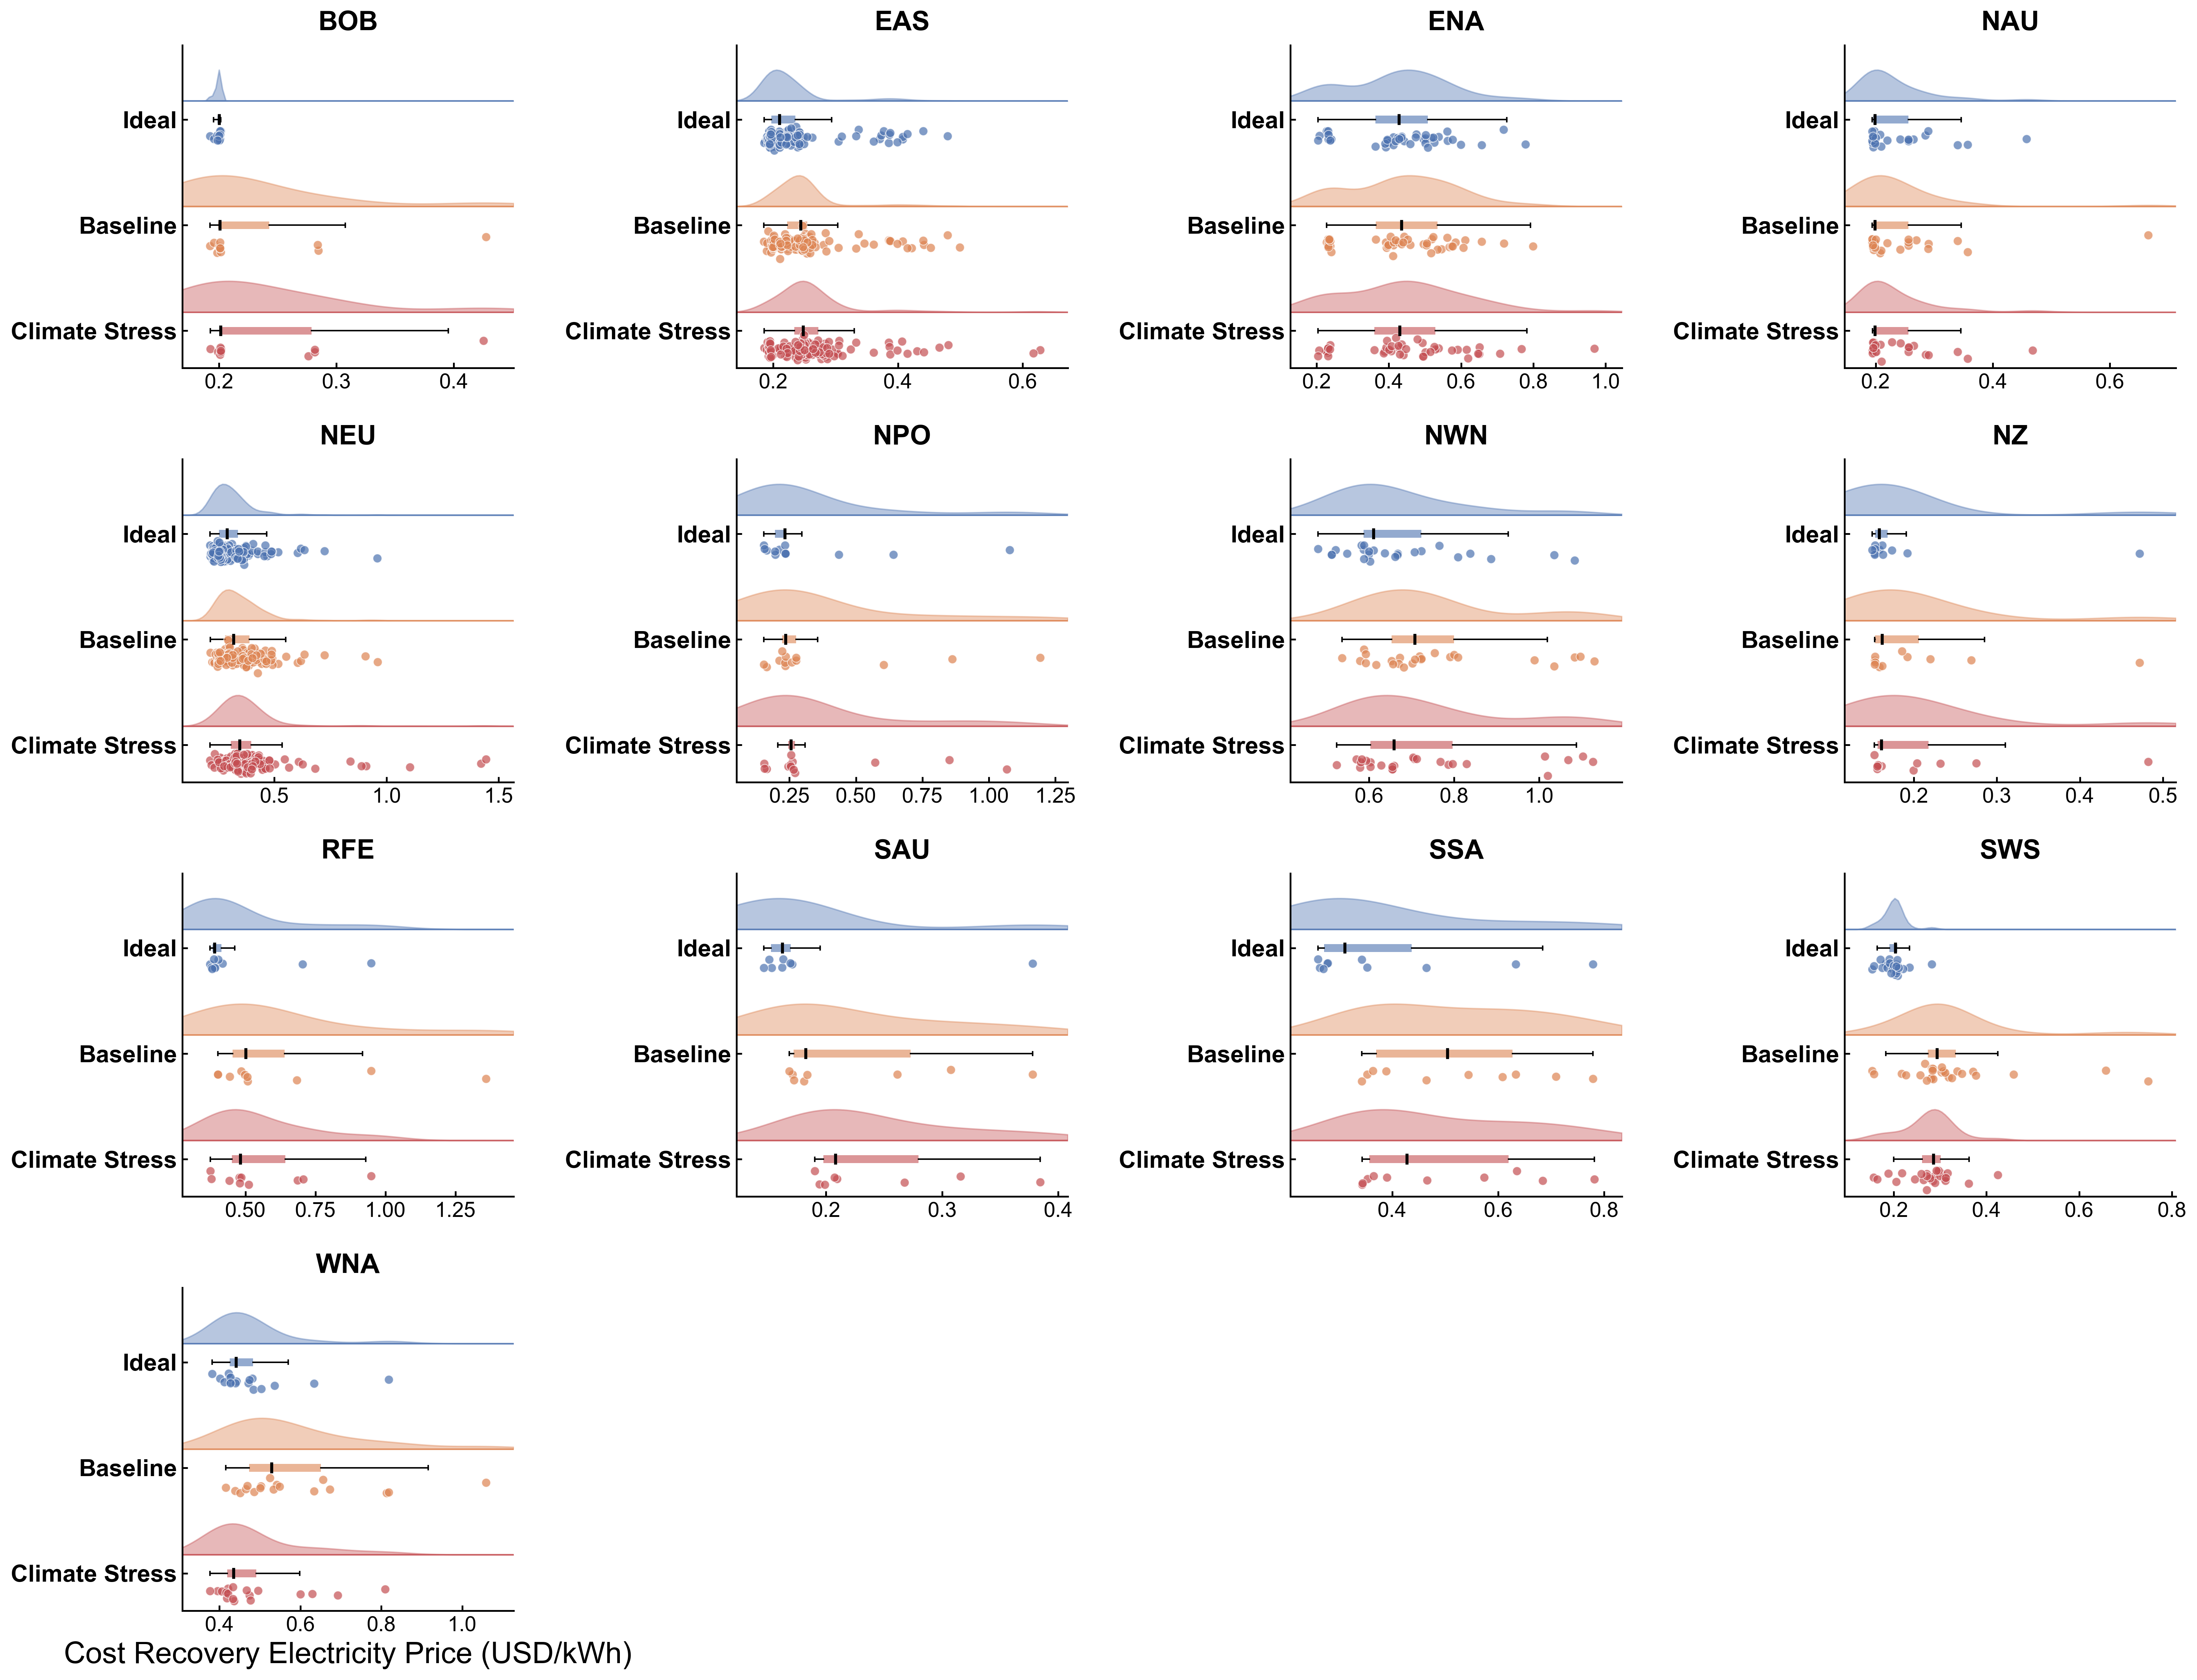


=== 三情景区域tariff_breakeven统计 ===

BOB:
  Ideal: 11 islands, median = 0.200, mean = 0.199
  2020: 11 islands, median = 0.201, mean = 0.235
  2050: 11 islands, median = 0.201, mean = 0.242

EAS:
  Ideal: 167 islands, median = 0.210, mean = 0.229
  2020: 167 islands, median = 0.244, mean = 0.252
  2050: 167 islands, median = 0.248, mean = 0.261

ENA:
  Ideal: 45 islands, median = 0.428, mean = 0.425
  2020: 45 islands, median = 0.436, mean = 0.436
  2050: 45 islands, median = 0.431, mean = 0.445

NAU:
  Ideal: 30 islands, median = 0.199, mean = 0.233
  2020: 30 islands, median = 0.199, mean = 0.240
  2050: 30 islands, median = 0.199, mean = 0.234

NEU:
  Ideal: 154 islands, median = 0.289, mean = 0.313
  2020: 154 islands, median = 0.319, mean = 0.349
  2050: 154 islands, median = 0.346, mean = 0.382

NPO:
  Ideal: 13 islands, median = 0.233, mean = 0.321
  2020: 13 islands, median = 0.236, mean = 0.379
  2050: 13 islands, median = 0.256, mean = 0.367

NWN:
  Ideal: 25 islands, median = 0

In [31]:
# 导入必要的库
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from matplotlib.patches import Rectangle
from pathlib import Path

# --- Nature 风格图表设置 ---
# (此部分保持不变)
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 20,
    'axes.labelsize': 20, # 统一x轴标签字号
    'axes.titlesize': 18,
    'xtick.labelsize': 14, # x轴刻度标签字号
    'ytick.labelsize': 16,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})


# --- 数据处理函数 ---
def assign_ipcc_region(lat, lon, ipcc_regions_gdf):
    """将岛屿坐标分配到IPCC区域"""
    point = Point(lon, lat)
    possible_matches_index = list(ipcc_regions_gdf.sindex.intersection(point.bounds))
    possible_matches = ipcc_regions_gdf.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.contains(point)]
    if not precise_matches.empty:
        return precise_matches.iloc[0]['Acronym']
    return 'Unknown'

def calculate_position_change(df_base, df_compare):
    """计算两个情景之间的位置变化 - 修正版，包含IPCC区域信息"""
    merged = pd.merge(df_base[['island_id', 'tariff_breakeven', 'ipcc_region']],
                      df_compare[['island_id', 'tariff_breakeven']],
                      on='island_id', suffixes=('_base', '_compare'))
    merged['position_change'] = abs(merged['tariff_breakeven_compare'] - merged['tariff_breakeven_base'])
    merged = merged.rename(columns={'ipcc_region': 'ipcc_region_base'})
    return merged

# <<<< 核心改动 1: 简化绘图函数，移除形状分类 >>>>
def create_raincloud_plot(data_ideal, data_2020, data_2050, 
                          ax, region_name, color_ideal, color_2020, color_2050):
    """
    创建改进的云雨图：每个scenario占据上中下三个区域，每个区域内从下到上是点-箱线图-半小提琴图。
    所有点使用相同的形状。
    x轴显示tariff_breakeven的原始数值。
    
    Args:
        data_ideal: Ideal情景的tariff_breakeven数值
        data_2020: 2020情景的tariff_breakeven数值  
        data_2050: 2050情景的tariff_breakeven数值
        ax: matplotlib轴对象
        region_name: IPCC区域名称
        color_ideal, color_2020, color_2050: 三个情景的颜色
    """
    # 计算数据范围
    all_data = np.concatenate([data_ideal, data_2020, data_2050])
    if len(all_data) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
        return
        
    x_min, x_max = all_data.min(), all_data.max()
    x_range = x_max - x_min if x_max != x_min else 1
    x_padding = x_range * 0.1  # x轴边距比例
    
    # 设置y轴位置
    y_ideal_points, y_ideal_box, y_ideal_violin = 0.72, 0.78, 0.84
    y_2020_points, y_2020_box, y_2020_violin = 0.38, 0.44, 0.50
    y_2050_points, y_2050_box, y_2050_violin = 0.04, 0.10, 0.16
    
    np.random.seed(42)  # 确保结果可重现
    
    def plot_scatter(data, y_base, color, jitter_std=0.015, point_size=35):
        """绘制统一形状的散点图"""
        if len(data) == 0:
            return
        y_jitter = np.random.normal(y_base, jitter_std, len(data))
        # 所有点都使用圆形 'o'
        ax.scatter(data, y_jitter, 
                   marker='o',
                   color=color,
                   alpha=0.7,
                   s=point_size,
                   edgecolors='white',
                   linewidth=0.5,
                   zorder=3)
    
    # --- 绘制函数 (此部分逻辑与原版类似，但调用的是新的 plot_scatter) ---
    # === Ideal Scenario（上部分）===
    if len(data_ideal) > 0:
        plot_scatter(data_ideal, y_ideal_points, color_ideal, point_size=35)
        # 箱线图
        q25, q50, q75 = np.percentile(data_ideal, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_ideal.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_ideal.max(), q75 + 1.5 * iqr)
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_ideal_box - box_height/2), q75 - q25, box_height, facecolor=color_ideal, alpha=0.6, zorder=2))
        ax.plot([q50, q50], [y_ideal_box - box_height/2, y_ideal_box + box_height/2], color='black', linewidth=2, zorder=4)
        ax.plot([whisker_low, q25], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_ideal_box, y_ideal_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_ideal_box - box_height/4, y_ideal_box + box_height/4], color='black', linewidth=1, zorder=2)
        # 半小提琴图
        if len(data_ideal) > 3:
            try:
                kde = stats.gaussian_kde(data_ideal)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density = kde(x_kde)
                density_scaled = density / density.max() * 0.10
                ax.fill_between(x_kde, y_ideal_violin, y_ideal_violin + density_scaled, alpha=0.4, color=color_ideal, zorder=1)
                ax.plot(x_kde, [y_ideal_violin] * len(x_kde), color=color_ideal, linewidth=1, alpha=0.8, zorder=1)
            except: pass
    
    # === 2020 Scenario（中部分）===
    if len(data_2020) > 0:
        plot_scatter(data_2020, y_2020_points, color_2020, point_size=35)
        # 箱线图
        q25, q50, q75 = np.percentile(data_2020, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2020.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2020.max(), q75 + 1.5 * iqr)
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2020_box - box_height/2), q75 - q25, box_height, facecolor=color_2020, alpha=0.6, zorder=2))
        ax.plot([q50, q50], [y_2020_box - box_height/2, y_2020_box + box_height/2], color='black', linewidth=2, zorder=4)
        ax.plot([whisker_low, q25], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2020_box, y_2020_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2020_box - box_height/4, y_2020_box + box_height/4], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2020_box - box_height/4, y_2020_box + box_height/4], color='black', linewidth=1, zorder=2)
        # 半小提琴图
        if len(data_2020) > 3:
            try:
                kde = stats.gaussian_kde(data_2020)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density = kde(x_kde)
                density_scaled = density / density.max() * 0.10
                ax.fill_between(x_kde, y_2020_violin, y_2020_violin + density_scaled, alpha=0.4, color=color_2020, zorder=1)
                ax.plot(x_kde, [y_2020_violin] * len(x_kde), color=color_2020, linewidth=1, alpha=0.8, zorder=1)
            except: pass

    # === 2050 Scenario（下部分）===
    if len(data_2050) > 0:
        plot_scatter(data_2050, y_2050_points, color_2050, point_size=35)
        # 箱线图
        q25, q50, q75 = np.percentile(data_2050, [25, 50, 75])
        iqr = q75 - q25
        whisker_low = max(data_2050.min(), q25 - 1.5 * iqr)
        whisker_high = min(data_2050.max(), q75 + 1.5 * iqr)
        box_height = 0.025
        ax.add_patch(plt.Rectangle((q25, y_2050_box - box_height/2), q75 - q25, box_height, facecolor=color_2050, alpha=0.6, zorder=2))
        ax.plot([q50, q50], [y_2050_box - box_height/2, y_2050_box + box_height/2], color='black', linewidth=2, zorder=4)
        ax.plot([whisker_low, q25], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([q75, whisker_high], [y_2050_box, y_2050_box], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_low, whisker_low], [y_2050_box - box_height/4, y_2050_box + box_height/4], color='black', linewidth=1, zorder=2)
        ax.plot([whisker_high, whisker_high], [y_2050_box - box_height/4, y_2050_box + box_height/4], color='black', linewidth=1, zorder=2)
        # 半小提琴图
        if len(data_2050) > 3:
            try:
                kde = stats.gaussian_kde(data_2050)
                x_kde = np.linspace(x_min - x_padding, x_max + x_padding, 100)
                density = kde(x_kde)
                density_scaled = density / density.max() * 0.10
                ax.fill_between(x_kde, y_2050_violin, y_2050_violin + density_scaled, alpha=0.4, color=color_2050, zorder=1)
                ax.plot(x_kde, [y_2050_violin] * len(x_kde), color=color_2050, linewidth=1, alpha=0.8, zorder=1)
            except: pass
    
    # 设置轴和标签
    ax.set_ylim(-0.02, 1.02)
    ax.set_yticks([0.10, 0.44, 0.78])
    ax.set_yticklabels(['Climate Stress', 'Baseline', 'Ideal'], fontweight='bold')
    ax.set_title(f'{region_name}', pad=10, fontweight='bold')
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(x_min - x_padding, x_max + x_padding)

# --- 主程序：创建多子图云雨图 ---
if __name__ == '__main__':
    # 筛选出有效区域
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")
    
    # Create the 'ipcc_region' column by applying the function to each row
    df['ipcc_region'] = df.apply(
        lambda row: assign_ipcc_region(row['lat'], row['lon'], ipcc_regions), 
        axis=1
    )
 
          
    MIN_ISLANDS_PER_REGION = 10
    region_counts = df['ipcc_region'].value_counts()
    valid_regions = region_counts[region_counts >= MIN_ISLANDS_PER_REGION].index.tolist()
    
    df_base_ideal = df[(df['scenario'] == 'output_0') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2020 = df[(df['scenario'] == 'output_2020') & (df['ipcc_region'].isin(valid_regions))].copy()
    df_compare_2050 = df[(df['scenario'] == 'output_2050') & (df['ipcc_region'].isin(valid_regions))].copy()
    
    change_2020 = calculate_position_change(df_base_ideal, df_compare_2020)
    change_2050 = calculate_position_change(df_base_ideal, df_compare_2050)
    
    significant_2020 = change_2020[change_2020['position_change'] > 0.1]
    significant_2050 = change_2050[change_2050['position_change'] > 0.1]
    
    regions_2020 = set(significant_2020['ipcc_region_base'].unique())
    regions_2050 = set(significant_2050['ipcc_region_base'].unique())
    common_regions = sorted(list(regions_2020.union(regions_2050))) # 排序以保证一致性

    if not common_regions:
        print("没有发现有显著变化的区域")
    else:
        print(f"发现 {len(common_regions)} 个有显著变化的区域: {common_regions}")
        print("开始生成三情景云雨图...")
        
        n_regions = len(common_regions)
        n_cols = min(4, n_regions)
        n_rows = (n_regions + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5.2 * n_cols, 4 * n_rows), squeeze=False)
        axes = axes.flatten()

        color_ideal = '#4C72B0'
        color_2020 = '#DD8452'
        color_2050 = '#C44E52'

        for i, region in enumerate(common_regions):
            ax = axes[i]
            region_df_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]
            region_df_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]
            region_df_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]

            region_data_ideal = region_df_ideal['tariff_breakeven'].values
            region_data_2020 = region_df_2020['tariff_breakeven'].values
            region_data_2050 = region_df_2050['tariff_breakeven'].values

            # <<<< 核心改动 2: 不再调用分类函数，直接绘图 >>>>
            create_raincloud_plot(
                region_data_ideal, region_data_2020, region_data_2050,
                ax, region, color_ideal, color_2020, color_2050
            )

        for i in range(n_regions, len(axes)):
            axes[i].set_visible(False)

        for i in range(n_regions):
            if i >= (n_rows - 1) * n_cols:
                axes[i].set_xlabel('Cost Recovery Electricity Price (USD/kWh)')

        # <<<< 核心改动 3: 移除了整个图例创建部分 >>>>
        
        plt.tight_layout()
        plt.show()

        # 打印统计信息 (保持不变)
        print(f"\n=== 三情景区域tariff_breakeven统计 ===")
        for region in common_regions:
            data_ideal = df_base_ideal[df_base_ideal['ipcc_region'] == region]['tariff_breakeven'].values
            data_2020 = df_compare_2020[df_compare_2020['ipcc_region'] == region]['tariff_breakeven'].values
            data_2050 = df_compare_2050[df_compare_2050['ipcc_region'] == region]['tariff_breakeven'].values
            print(f"\n{region}:")
            if len(data_ideal) > 0: print(f"  Ideal: {len(data_ideal)} islands, median = {np.median(data_ideal):.3f}, mean = {np.mean(data_ideal):.3f}")
            if len(data_2020) > 0: print(f"  2020: {len(data_2020)} islands, median = {np.median(data_2020):.3f}, mean = {np.mean(data_2020):.3f}")
            if len(data_2050) > 0: print(f"  2050: {len(data_2050)} islands, median = {np.median(data_2050):.3f}, mean = {np.mean(data_2050):.3f}")


--- 正在对比三个情景 ---
发现 171 个有显著变化的岛屿（在 output_0 和 output_2020 之间）。


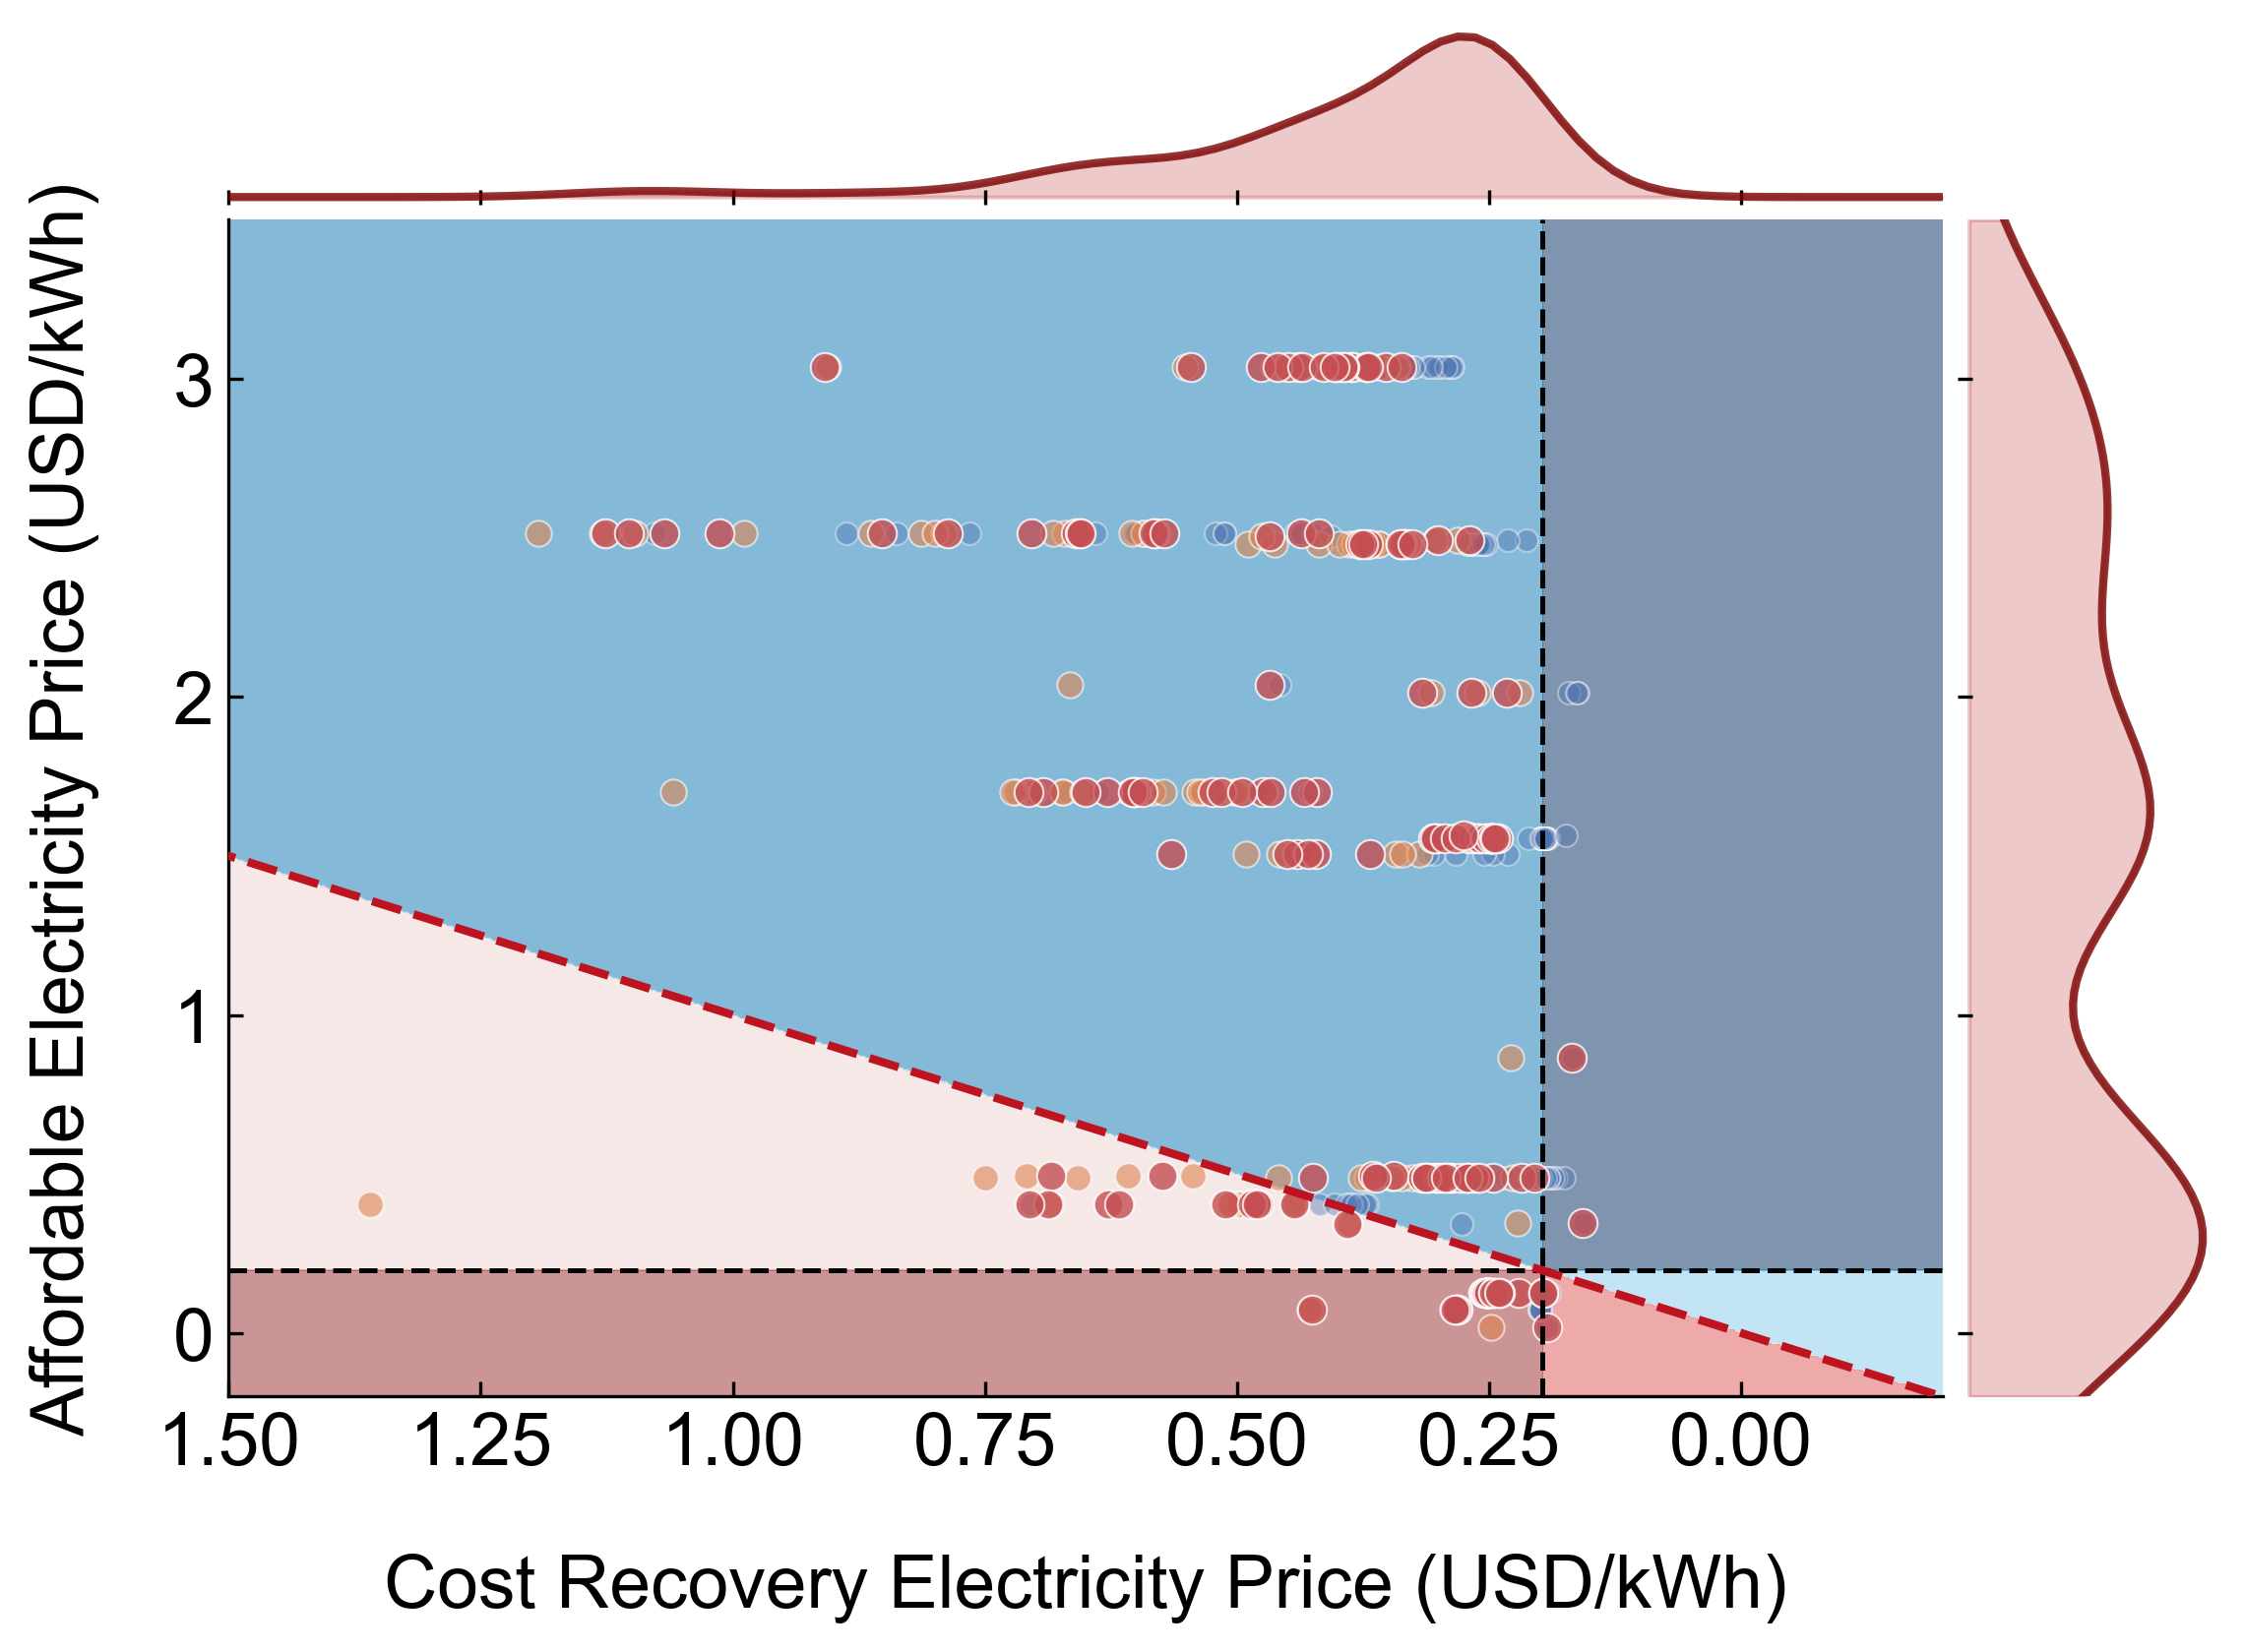


--- Q1-Q6 统计分析结果 (仅针对显著变化的岛屿) ---
                Q1   Q2  Q3  Q4  Q5  Q6
Scenario                               
Ideal           28  106   0   2  21  14
Baseline         0  121   0  15   0  35
Climate Stress   2  122   0  12   3  32
--------------------------------------------------


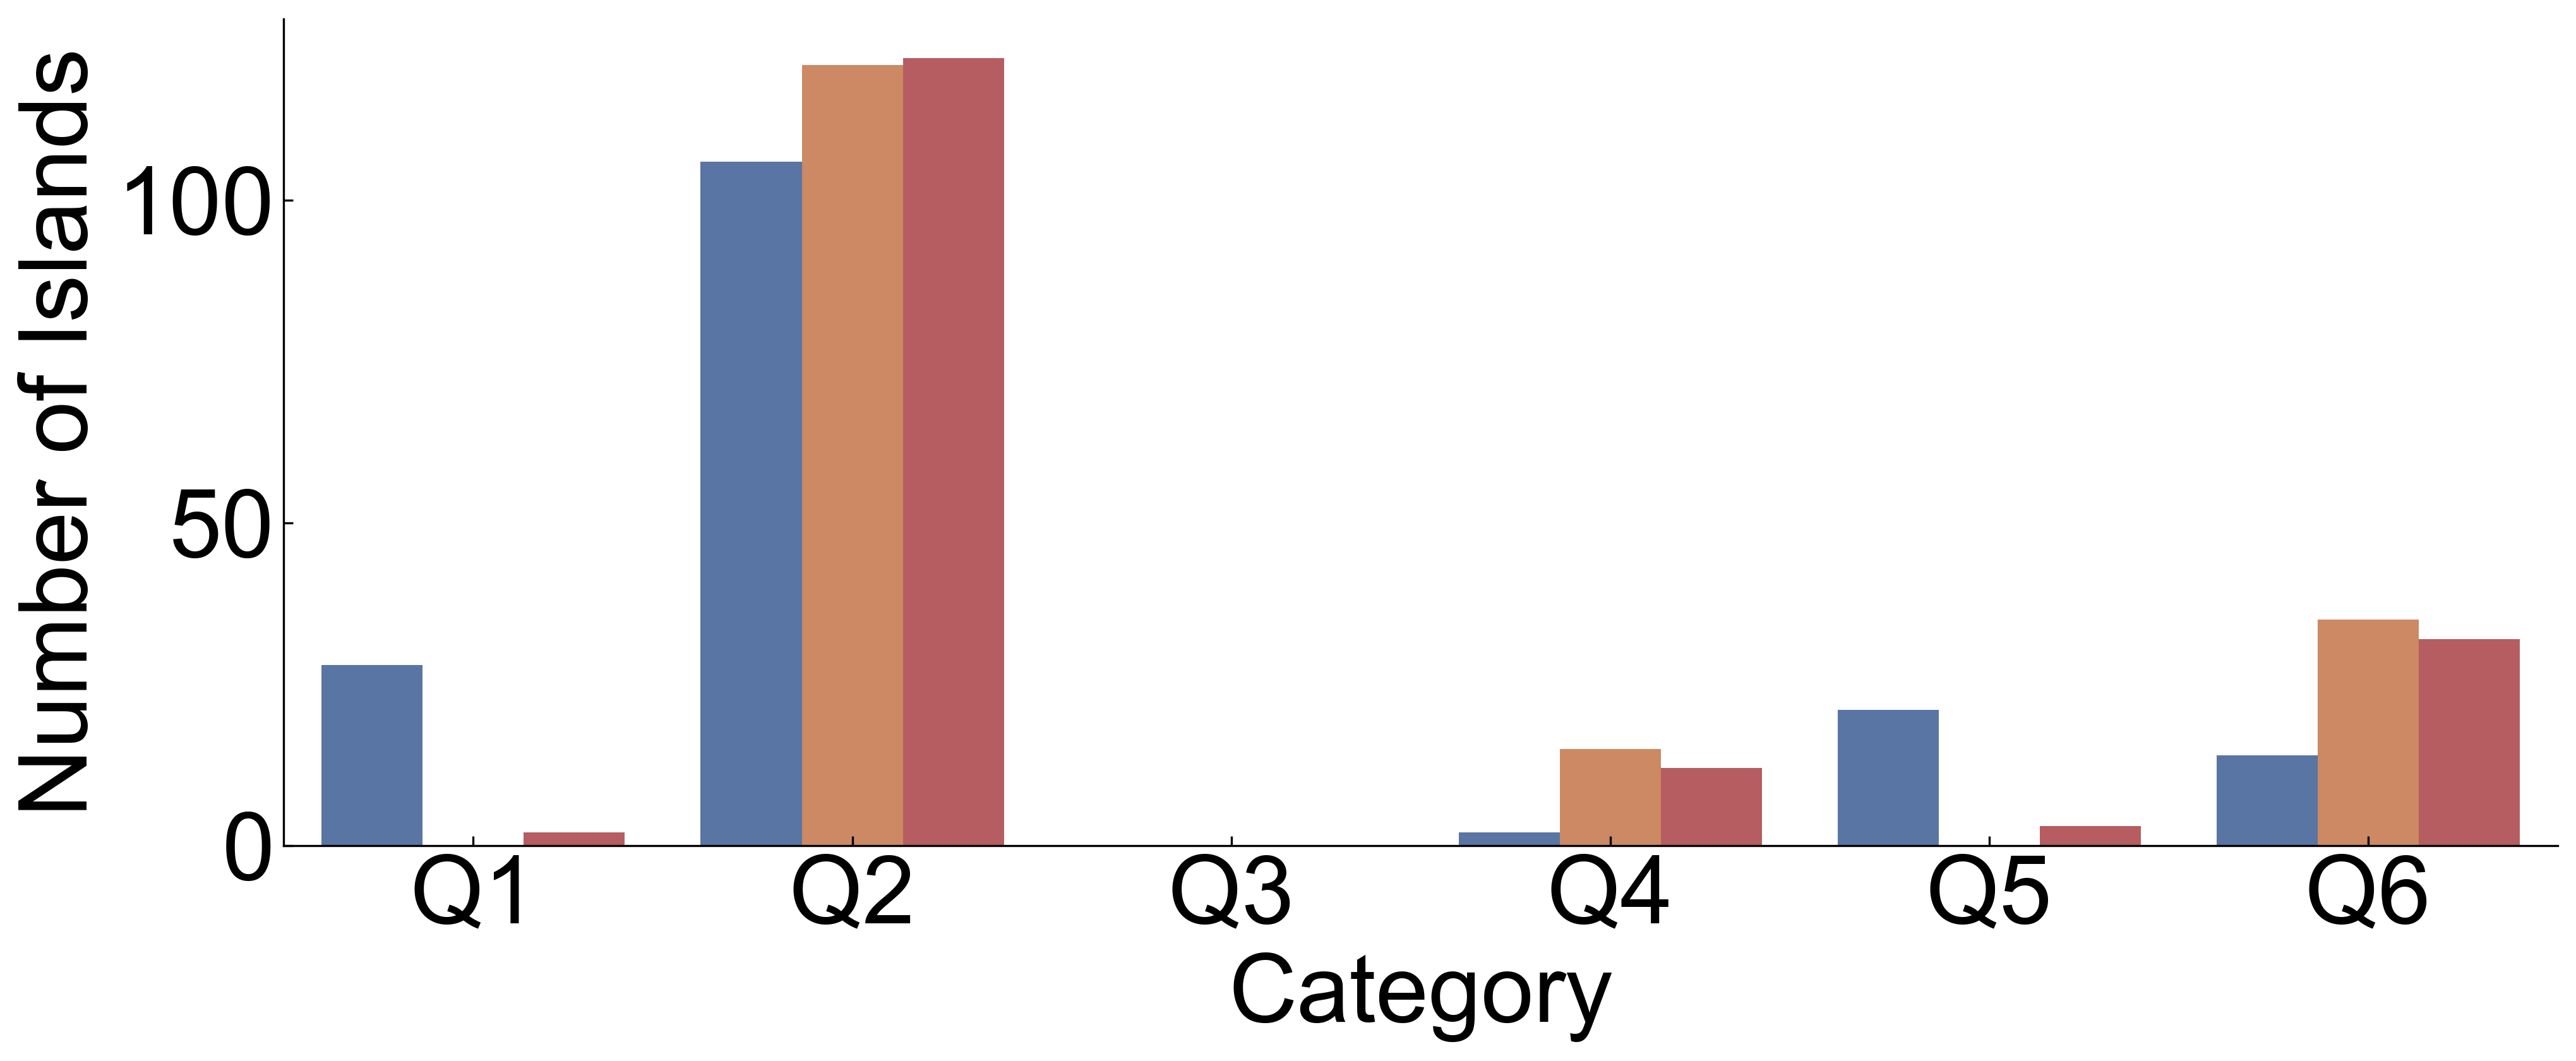

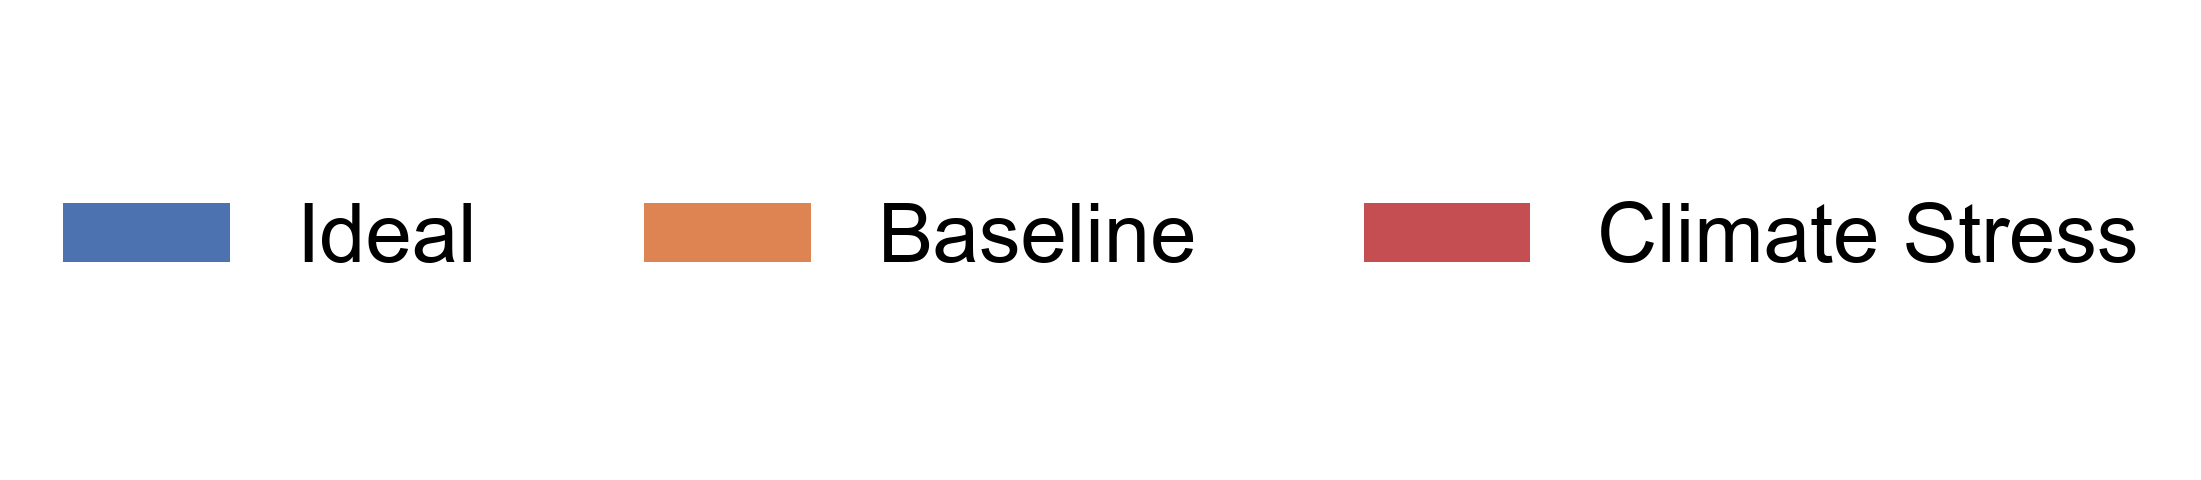

In [40]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# --- Nature 风格图表设置 ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 20,
    'axes.labelsize': 18,
    'axes.titlesize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'figure.dpi': 300,
    'axes.linewidth': 0.8,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
})

# --- 六区域定义 (保持不变) ---
SIX_REGION_NAMES = [
    "Feasible\nLow Cost\nHigh Affordability",      # 区域1
    "Feasible\nHigh Cost\nHigh Affordability",     # 区域2
    "Feasible\nLow Cost\nLow Affordability",       # 区域3
    "Infeasible\nHigh Cost\nHigh Affordability",   # 区域4
    "Infeasible\nLow Cost\nLow Affordability",     # 区域5
    "Infeasible\nHigh Cost\nLow Affordability",    # 区域6
]

# --- NEW: Define colors for the six regions ---
# Added to support the background drawing function
SIX_REGION_COLORS = {
    SIX_REGION_NAMES[0]: '#012A61', # 深蓝 (最理想)
    SIX_REGION_NAMES[1]: '#0B75B3', # 中蓝
    SIX_REGION_NAMES[2]: '#89CAEA', # 浅蓝 (勉强可行)
    SIX_REGION_NAMES[3]: "#F0D2D2", # 浅红 (成本问题)
    SIX_REGION_NAMES[4]: '#DC5654', # 中红 (支付能力问题)
    SIX_REGION_NAMES[5]: '#982B2D', # 深红 (最棘手)
}


# --- 核心分类函数 (保持不变) ---
def classify_point(x, y, median_breakeven):
    """根据成本中位数对单个点(x,y)进行六区域分类"""
    is_low_cost = x <= median_breakeven
    is_high_affordability_benchmark = y > median_breakeven
    is_feasible = y >= x
    if is_feasible:
        if is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[0]
        elif not is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[1]
        elif is_low_cost and not is_high_affordability_benchmark: return SIX_REGION_NAMES[2]
        else: return SIX_REGION_NAMES[5]
    else: # Infeasible
        if not is_low_cost and is_high_affordability_benchmark: return SIX_REGION_NAMES[3]
        elif is_low_cost and not is_high_affordability_benchmark: return SIX_REGION_NAMES[4]
        elif not is_low_cost and not is_high_affordability_benchmark: return SIX_REGION_NAMES[5]
        else: return SIX_REGION_NAMES[3]

# <<<< MODIFIED: 统计函数现在接收一个标签映射字典 >>>>
def analyze_and_plot_statistics(df_analysis, scenario_config, median_breakeven, label_mapping):
    """
    对数据进行六区域分类，并根据提供的 label_mapping 绘制 Q1-Q6 条形图。
    """
    results = []
    
    # 获取排序好的Q标签列表，例如 ['Q1', 'Q2', ..., 'Q6']
    ordered_q_labels = sorted(list(set(label_mapping.values())))

    # 1. 遍历每个情景进行统计
    for scenario_name, config in scenario_config.items():
        scenario_df = df_analysis[df_analysis['scenario'] == scenario_name].copy()
        if scenario_df.empty:
            continue

        # 应用六区域分类
        scenario_df['region'] = scenario_df.apply(
            lambda row: classify_point(row['tariff_breakeven'], row['tariff_affordable'], median_breakeven),
            axis=1
        )
        
        counts = scenario_df['region'].value_counts().to_dict()
        
        # 使用映射表来聚合结果
        q_counts = {q_label: 0 for q_label in ordered_q_labels}
        for region_name, q_label in label_mapping.items():
            q_counts[q_label] += counts.get(region_name, 0)
        
        result_row = {'Scenario': config['label'], **q_counts}
        results.append(result_row)
        
    if not results:
        print("没有可供分析的数据。")
        return
        
    # 2. 创建并打印统计结果的DataFrame
    stats_df = pd.DataFrame(results).set_index('Scenario')
    print("\n--- Q1-Q6 统计分析结果 (仅针对显著变化的岛屿) ---")
    print(stats_df[ordered_q_labels]) # 按Q1-Q6顺序打印
    print("-" * 50)
    
    # 3. 准备绘图数据
    stats_df_melted = stats_df.reset_index().melt(
        id_vars='Scenario',
        var_name='Category',
        value_name='Number of Islands'
    )
    
    palette = {config['label']: config['color'] for config in scenario_config.values()}
    
    # 4. 创建竖向条形图
    fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
    
    sns.barplot(
        data=stats_df_melted,
        x='Category',
        y='Number of Islands',
        hue='Scenario',
        palette=palette,
        ax=ax,
        legend=False,
        order=ordered_q_labels # 使用Q1-Q6排序
    )
    
    # 5. 美化图表
    ax.set_ylabel('Number of Islands', fontsize=36)
    ax.set_xlabel('Category', fontsize=36) # 添加X轴标签
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='y', labelsize=36)
    ax.tick_params(axis='x', labelsize=36) # 调整X轴标签字号
    
    fig.tight_layout()
    plt.show()
    
    # 6. 单独创建图例
    fig_legend, ax_legend = plt.subplots(figsize=(8, 2), dpi=300)
    ax_legend.axis('off')
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=config['color'], label=config['label']) 
                       for config in scenario_config.values()]
    legend = ax_legend.legend(handles=legend_elements, loc='center', ncol=len(scenario_config), fontsize=20, frameon=False)
    for text in legend.get_texts():
        text.set_fontweight('normal')
    fig_legend.tight_layout()
    plt.show()

# --- 辅助函数：计算位置变化 (保持不变) ---
def calculate_position_change(df_base, df_final):
    """计算岛屿在两个情景之间位置变化的欧几里得距离"""
    merged = pd.merge(df_base, df_final, on='island_id', suffixes=('_base', '_final'))
    merged['position_change'] = np.sqrt(
        (merged['tariff_breakeven_final'] - merged['tariff_breakeven_base'])**2 +
        (merged['tariff_affordable_final'] - merged['tariff_affordable_base'])**2
    )
    return merged[['island_id', 'position_change']]


# --- NEW: Background plotting function ---
def draw_six_region_backgrounds(ax, median_breakeven, xlim, ylim):
    """
    使用网格化和 contourf 的方法精确绘制六个区域的背景色。
    """
    x_min, x_max = xlim
    y_min, y_max = ylim
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 500),
        np.linspace(y_min, y_max, 500)
    )
    
    region_to_id = {name: i for i, name in enumerate(SIX_REGION_NAMES)}
    
    vectorized_classify = np.vectorize(classify_point)
    # 注意这里只传递 median_breakeven
    grid_regions = vectorized_classify(xx, yy, median_breakeven)
    
    Z = np.zeros(grid_regions.shape)
    for name, region_id in region_to_id.items():
        Z[grid_regions == name] = region_id
        
    colors = [SIX_REGION_COLORS[name] for name in SIX_REGION_NAMES]
    cmap = matplotlib.colors.ListedColormap(colors)
    
    levels = np.arange(-0.5, len(colors), 1)
    # Use a lower alpha for background, ensure zorder is low
    ax.contourf(xx, yy, Z, levels=levels, cmap=cmap, alpha=0.5, zorder=0)


# --- 核心绘图函数 ---
def plot_three_scenario_changes(df, base_scenario, final_scenario, zoom_config, scenario_config, change_threshold=0.1):
    """
    筛选出在首尾情景间有显著变化的岛屿，绘制它们的位置，并进行六区域统计分析。
    """
    if df.empty:
        print("数据为空，跳过绘图。")
        return

    df_base = df[df['scenario'] == base_scenario]
    df_final = df[df['scenario'] == final_scenario]

    if df_base.empty or df_final.empty:
        print(f"缺少 {base_scenario} 或 {final_scenario} 的数据，无法计算变化。")
        return

    change_data = calculate_position_change(df_base, df_final)
    significant_changes = change_data[change_data['position_change'] > change_threshold]

    if significant_changes.empty:
        print(f"在阈值 {change_threshold} 下未发现显著变化的岛屿。")
        return

    significant_island_ids = significant_changes['island_id'].unique()
    print(f"发现 {len(significant_island_ids)} 个有显著变化的岛屿（在 {base_scenario} 和 {final_scenario} 之间）。")

    df_plot = df[df['island_id'].isin(significant_island_ids)].copy()

    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    divider = make_axes_locatable(ax)
    ax_top = divider.append_axes("top", size="15%", pad=0.05, sharex=ax)
    ax_right = divider.append_axes("right", size="15%", pad=0.05, sharey=ax)

    plt.setp(ax_top.get_xticklabels(), visible=False)
    plt.setp(ax_right.get_yticklabels(), visible=False)

    # --- Set axes limits first ---
    ax.set_xlim(1.5, -0.2)
    ax.set_ylim(-0.2, 3.5)
    
    median_breakeven = df_base['tariff_breakeven'].median()

    # --- MODIFICATION: Draw background ---
    # This is the newly added part.
    draw_six_region_backgrounds(ax, median_breakeven, ax.get_xlim(), ax.get_ylim())
    # --- END OF MODIFICATION ---

    for scenario_name, config in scenario_config.items():
        scenario_df = df_plot[df_plot['scenario'] == scenario_name]
        if not scenario_df.empty:
            ax.scatter(scenario_df['tariff_breakeven'], scenario_df['tariff_affordable'],
                       color=config['color'], label=config['label'],
                       alpha=config['alpha'], s=config['size'], edgecolors='white', linewidth=0.5, zorder=3)

    ax.set_xlabel('Cost Recovery Electricity Price (USD/kWh)', labelpad=18)
    ax.set_ylabel('Affordable Electricity Price (USD/kWh)', labelpad=18)
    # ax.invert_xaxis()
    ax.spines[['right', 'top']].set_visible(False)

    ax.axvline(x=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=5)
    ax.axhline(y=median_breakeven, color='black', linestyle='--', linewidth=1.2, zorder=5)

    lim_min = min(ax.get_xlim()[1], ax.get_ylim()[0])
    lim_max = max(ax.get_xlim()[0], ax.get_ylim()[1])
    ax.plot([lim_max, lim_min], [lim_max, lim_min], color='#be1420', linestyle='--',
            alpha=1, linewidth=2, label='Break-even line', zorder=5)
    ax.grid(False)

    red_scenario_data = df_plot[df_plot['scenario'] == 'output_2050']
    if not red_scenario_data.empty and len(red_scenario_data) > 3:
        try:
            x_data = red_scenario_data['tariff_breakeven'].values
            if len(x_data) > 1:
                kde_x = stats.gaussian_kde(x_data)
                x_range = np.linspace(ax.get_xlim()[1], ax.get_xlim()[0], 100)
                density_x = kde_x(x_range)
                ax_top.plot(x_range, density_x, color='#7a0101', linewidth=2, alpha=0.8)
                ax_top.fill_between(x_range, density_x, alpha=0.3, color='#C44E52')
                ax_top.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
                ax_top.set_yticks([])
                ax_top.set_facecolor('none')
            y_data = red_scenario_data['tariff_affordable'].values
            if len(y_data) > 1:
                kde_y = stats.gaussian_kde(y_data)
                y_range = np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100)
                density_y = kde_y(y_range)
                ax_right.plot(density_y, y_range, color='#7a0101', linewidth=2, alpha=0.8)
                ax_right.fill_betweenx(y_range, density_y, alpha=0.3, color='#C44E52')
                ax_right.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
                ax_right.set_xticks([])
                ax_right.set_facecolor('none')
        except Exception as e:
            print(f"密度图绘制失败: {e}")
            pass

    fig.tight_layout()
    plt.show()

    # <<<< MODIFIED: 定义自定义映射并调用新的分析函数 >>>>
    
    # --- 在这里自定义您的区域和Q标签的对应关系 ---
    # 键: SIX_REGION_NAMES[i] (内部区域名)
    # 值: "Qx" (您希望在图上显示的标签)
    q_label_mapping = {
        SIX_REGION_NAMES[0]: "Q1",  # Feasible, Low Cost, High Affordability
        SIX_REGION_NAMES[1]: "Q2",  # Feasible, High Cost, High Affordability
        SIX_REGION_NAMES[2]: "Q3",  # Feasible, Low Cost, Low Affordability
        SIX_REGION_NAMES[3]: "Q4",  # Infeasible, High Cost, High Affordability
        SIX_REGION_NAMES[4]: "Q5",  # Infeasible, Low Cost, Low Affordability
        SIX_REGION_NAMES[5]: "Q6"   # Infeasible, High Cost, Low Affordability
    }
    # --------------------------------------------------

    analyze_and_plot_statistics(df_plot, scenario_config, median_breakeven, label_mapping=q_label_mapping)


# ===== 主程序 =====
if __name__ == '__main__':
    # --- 2. 绘图配置 ---
    ZOOM_BOX = {
        'x_min': 0.08, 'x_max': 0.9,
        'y_min': -0.12, 'y_max': 1
    }

    SCENARIO_CONFIG = {
        'output_0': {
            'label': 'Ideal', 'color': '#4C72B0', 'alpha': 0.4, 'size': 30, 'zorder': 2
        },
        'output_2020': {
            'label': 'Baseline', 'color': '#DD8452', 'alpha': 0.6, 'size': 40, 'zorder': 3
        },
        'output_2050': {
            'label': 'Climate Stress', 'color': '#C44E52', 'alpha': 0.8, 'size': 50, 'zorder': 4
        }
    }

    # --- 3. 筛选并绘图 ---
    scenarios_to_plot = list(SCENARIO_CONFIG.keys())
    df_filtered = df[df['scenario'].isin(scenarios_to_plot)].copy()

    print(f"\n--- 正在对比三个情景 ---")
    
    if not df_filtered.empty:
        plot_three_scenario_changes(
            df=df_filtered,
            base_scenario='output_0',
            final_scenario='output_2020',
            zoom_config=ZOOM_BOX,
            scenario_config=SCENARIO_CONFIG,
            change_threshold=0.05 
        )
    else:
        print("没有足够的数据用于绘图。")


开始创建点密度世界地图...
发现 171 个有显著变化的岛屿
显著变化岛屿的IPCC区域分布:
ipcc_region
NEU    37
SEA    29
EAS    27
SWS    22
NWN    16
WNA     8
RFE     7
NPO     6
SSA     5
BOB     3
ENA     3
SAU     2
NZ      2
SPO     1
GIC     1
MDG     1
NAU     1
Name: count, dtype: int64
点大小范围: 50.0 - 500.0
变化量范围: 0.050 - 0.655


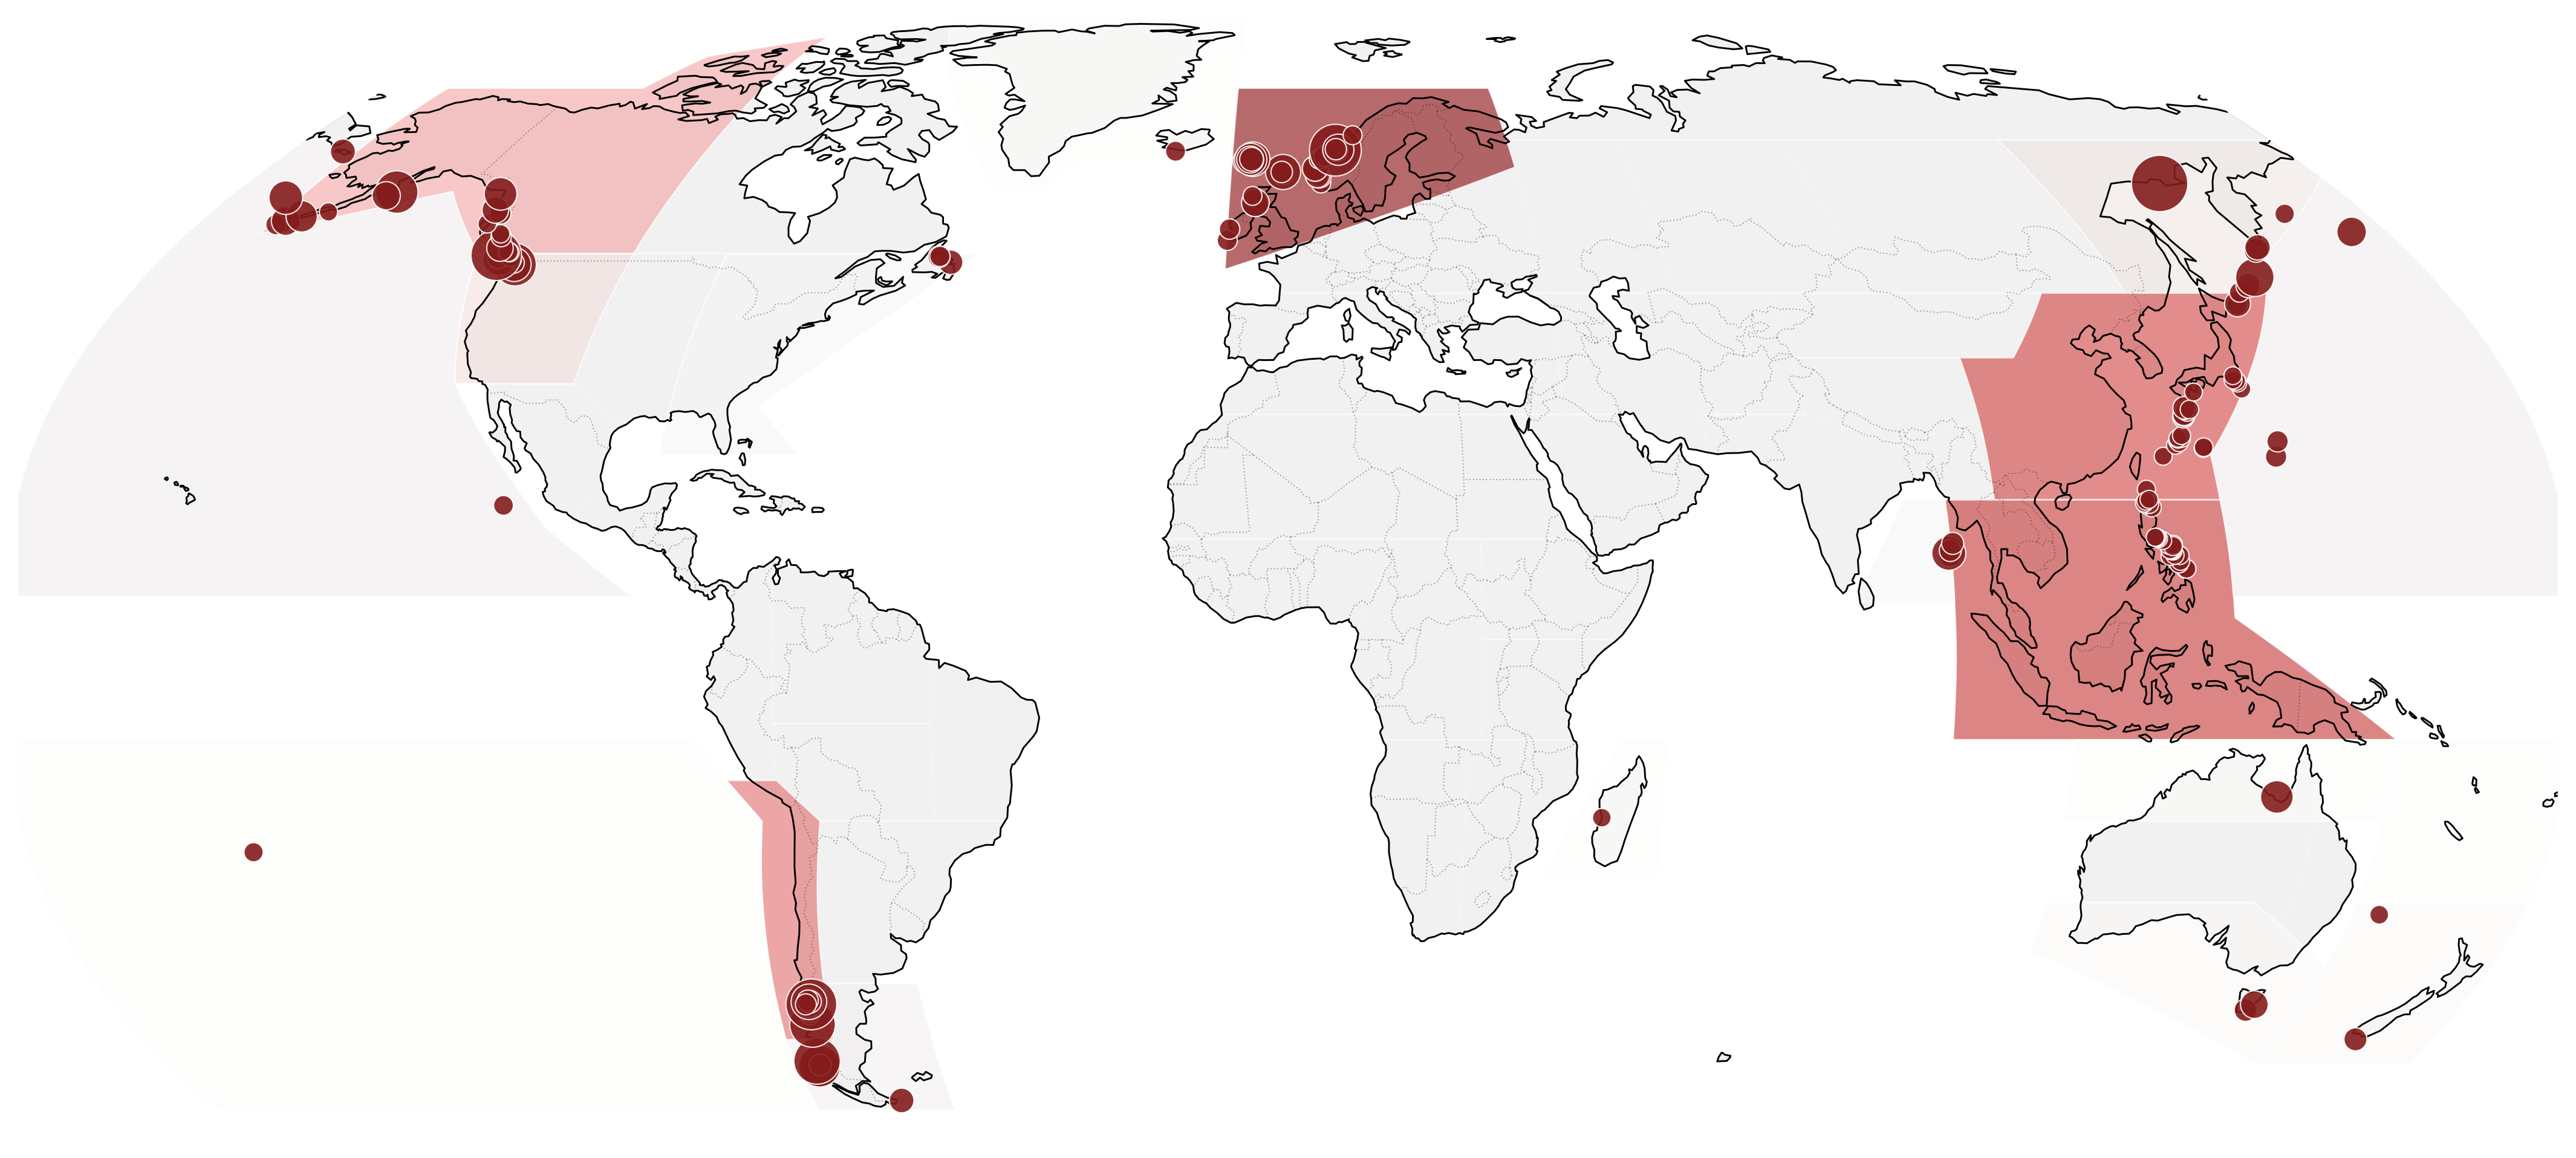


=== 世界地图统计摘要 ===
总共标记了 171 个有显著变化的岛屿
涉及 17 个IPCC区域
变化最多的区域: NEU (37 个岛屿)


In [8]:
# 7. --- 基于有明显变化岛屿的点密度世界地图 ---

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter

print("开始创建点密度世界地图...")

# 计算岛屿变化数据
df_base = df[(df['scenario'] == 'output_0')].copy()
df_compare = df[(df['scenario'] == 'output_2020')].copy()

# 使用现有的calculate_position_change函数
change_data = calculate_position_change(df_base, df_compare)
significant_changes = change_data[change_data['position_change'] > 0.05]  # 显著变化阈值

print(f"发现 {len(significant_changes)} 个有显著变化的岛屿")

if len(significant_changes) > 0:
    # 获取有显著变化岛屿的位置信息
    significant_islands = df_base[df_base['island_id'].isin(significant_changes['island_id'])].copy()
    
    # 将变化量信息合并到岛屿数据中
    significant_islands = significant_islands.merge(
        significant_changes[['island_id', 'position_change']], 
        on='island_id', how='left'
    )
    
    print(f"显著变化岛屿的IPCC区域分布:")
    region_counts = significant_islands['ipcc_region'].value_counts()
    print(region_counts)
    
    # 读取IPCC区域地理数据
    ipcc_regions = gpd.read_file("IPCC-WGI-reference-regions-v4.geojson")

    # 创建世界地图
    fig = plt.figure(figsize=(14, 8.5), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # 设置背景和地图特征
    ax.set_facecolor("#FFFFFF")
    ax.add_feature(cfeature.LAND, color="#CECECE", alpha=0.4)
    ax.add_feature(cfeature.OCEAN, color="#FFFFFF", alpha=0.5)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5, alpha=0.3)
    
    # 计算每个IPCC区域的显著变化岛屿数量
    if not region_counts.empty:
        # 创建红色渐变色彩映射（白色到深红色）
        vmin, vmax = region_counts.min(), region_counts.max()
        norm = Normalize(vmin=0, vmax=vmax)  # 从0开始，确保没有岛屿的区域为白色
        
        # 创建自定义红色渐变色彩映射
        colors = ['#FFFFFF', '#F1EEED', '#FCCDC9', '#EE9D9F', '#DE6A69', '#C84747', '#982B2D']  # 白色到深红色渐变
        red_colormap = LinearSegmentedColormap.from_list('red_gradient', colors, N=256)
        
        # 为每个IPCC区域着色
        for _, region_row in ipcc_regions.iterrows():
            region_code = region_row['Acronym']
            
            if region_code in region_counts.index:
                # 该区域有显著变化的岛屿
                island_count = region_counts[region_code]
                color = red_colormap(norm(island_count))
                alpha = 0.7  # 有数据的区域更不透明
                
                # 绘制填充的区域
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor=color,
                                  edgecolor='white',
                                  linewidth=0.5,
                                  alpha=alpha,
                                  zorder=1)
            else:
                # 该区域没有显著变化的岛屿，保持浅色
                ax.add_geometries([region_row['geometry']], crs=ccrs.PlateCarree(),
                                  facecolor='white',
                                  edgecolor="#FFFFFF",
                                  linewidth=0.3,
                                  alpha=0.3,
                                  zorder=1)
    
    # 在地图上标注显著变化的岛屿点 - 根据变化量调整点的大小
    if not significant_islands.empty:
        # 计算点大小：根据position_change缩放
        change_values = significant_islands['position_change'].values
        min_change = change_values.min()  # 最小变化量
        max_change = change_values.max()  # 最大变化量
        
        # 设置点大小范围
        min_size = 50   # 最小点大小
        max_size = 500  # 最大点大小
        
        # 线性缩放点大小：变化量越大，点越大
        if max_change > min_change:
            normalized_changes = (change_values - min_change) / (max_change - min_change)  # 归一化到0-1
            point_sizes = min_size + normalized_changes * (max_size - min_size)  # 缩放到指定范围
        else:
            # 如果所有变化量相同，使用中等大小
            point_sizes = np.full(len(change_values), (min_size + max_size) / 2)
        
        # 使用深红色圆点标记有显著变化的岛屿
        scatter = ax.scatter(significant_islands['lon'], significant_islands['lat'],
                   transform=ccrs.PlateCarree(),  # 坐标转换
                   c="#841C1C",  # 深红色点
                   s=point_sizes,  # 根据变化量调整点大小
                   alpha=0.9,  # 透明度参数，让点更加明显
                   edgecolors='white',  # 白色边框
                   linewidth=0.5,  # 边框宽度参数
                   zorder=3)  # 确保点显示在最上层
        
        print(f"点大小范围: {point_sizes.min():.1f} - {point_sizes.max():.1f}")
        print(f"变化量范围: {min_change:.3f} - {max_change:.3f}")
    
    # 设置视图范围，排除南极洲
    ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
    
    # 添加颜色条图例
    # if not region_counts.empty:
    #     # 创建颜色条
    #     sm = cm.ScalarMappable(norm=norm, cmap=red_colormap)
    #     sm.set_array([])
        
    #     # 在右侧添加颜色条
    #     cbar = plt.colorbar(sm, ax=ax, orientation='vertical', 
    #                        pad=0.02, shrink=0.6, aspect=20)
    #     cbar.set_label('Number of Islands with Significant Changes', 
    #                    rotation=270, labelpad=20, fontsize=20)  # 颜色条标签
    #     cbar.ax.tick_params(labelsize=10)  # 颜色条刻度标签大小参数
    
    # 添加标题
    # ax.set_title('Global Distribution of Islands with Significant Tariff Changes\n(Baseline vs Climate Stress Scenarios)', 
    #              fontsize=14, fontweight='bold', pad=20)
    
    # 去除坐标轴刻度
    ax.set_xticks([])
    ax.set_yticks([])
    # 去除边框
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # 去除所有边距，只显示图像内容
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.show()
    
    # 打印统计摘要
    print(f"\n=== 世界地图统计摘要 ===")
    print(f"总共标记了 {len(significant_islands)} 个有显著变化的岛屿")
    print(f"涉及 {len(region_counts)} 个IPCC区域")
    print(f"变化最多的区域: {region_counts.index[0]} ({region_counts.iloc[0]} 个岛屿)")
    
else:
    print("没有发现显著变化的岛屿，无法创建地图可视化")